In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import eli5

import warnings
warnings.filterwarnings('ignore')

## 1. Загрузить Данные

In [2]:
data_raw = pd.read_csv("healthcare-dataset-stroke-data.csv")

## 2 Описание Задачи
Прогнозирование вероятности Инсульта у пациента, на основании доступной информации.
Инсульт находится на втором месте,после сердечно-сосудистых заболеваний. На него приходится около 11% всех смертей.
Основные внутренние причины инсульта: повышенное давление, наличие сердечных заболеваний, Повышенный сахар в крови, избыточный вес.
Дополнительные внешние причины которые могут повлечь инсульт:возраст, алкоголь,сигареты,переутомление, стресс.



в таблице приведены колонки с данными

* 1) id: идентификатор пациента
* 2) gender: пол:Мужской,Женский и Другой 
* 3) age: Возраст
* 4) hypertension: Наличие Гипертонии, где 1 истина, 0 ложь
* 5) heart_disease: Наличие сердечных заболеваний, где 1 истина, 0 ложь
* 6) ever_married: в браке пациент или нет
* 7) work_type: тип работы: Ребенок, Самозанятый,Частный, Государственная и никогда не работал
* 8) Residence_type: Место проживания: Городской или сельский тип жилья
* 9) avg_glucose_level: Средний уровень глюкозы
* 10) bmi: индекс массы тела
* 11) smoking_status: отношение к курению: Ранее курил, никогда не курил, курит или неизвестно
* 12) stroke: произошел ли инсульт, Где 1 истина, 0 ложь


In [3]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB



Проверим есть ли не заполненные ячейки и заполним их медианным значением

In [4]:
data_raw.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [5]:
data_raw['bmi'] = data_raw['bmi'].fillna(data_raw['bmi'].mean())
data_raw.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Проверим на несбалансированность классов

In [6]:
data1=data_raw[data_raw['stroke'] != 0]
print(len(data1['stroke']))
data2=data_raw[data_raw['stroke'] != 1]
print(len(data2['stroke']))

249
4861


Из-за несбалансированности, воспользуемся Smote. Перед этим обработаем данные

Исключим строки пола Другое  и удалим колонку id

In [7]:
data_raw=data_raw[data_raw['gender'] != "Other"]
print(data_raw['gender'].value_counts())

Female    2994
Male      2115
Name: gender, dtype: int64


In [8]:
data_raw = data_raw.drop(['id'], axis=1)

Преоразуем object в int создав словари

In [9]:
s={'formerly smoked':0,'never smoked':1,'smokes':2,'Unknown':3}
data_raw['smoking_status'] =data_raw['smoking_status'].apply(lambda data_raw:s[data_raw]) 

In [10]:
w={'children':0,'Govt_job':1,'Never_worked':2,'Private':3,'Self-employed':4}
data_raw['work_type'] =data_raw['work_type'].apply(lambda data_raw:w[data_raw]) 

In [11]:
r={'Rural':0,'Urban':1}
data_raw['Residence_type'] =data_raw['Residence_type'].apply(lambda data_raw:r[data_raw]) 

In [12]:
e={'No':0,'Yes':1}
data_raw['ever_married'] =data_raw['ever_married'].apply(lambda data_raw:e[data_raw]) 

In [13]:
d={'Male':0,'Female':1}
data_raw['gender'] =data_raw['gender'].apply(lambda data_raw:d[data_raw]) 

In [14]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   int64  
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   int64  
 5   work_type          5109 non-null   int64  
 6   Residence_type     5109 non-null   int64  
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   int64  
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 479.0 KB


Предварительная работа с данными

In [15]:
from imblearn.over_sampling import SMOTE

In [16]:
sm = SMOTE(random_state=42, k_neighbors=5)

In [17]:
X = data_raw.drop(['stroke'], axis=1)
y = data_raw['stroke']# наша целевая

In [18]:
X_res, y_res = sm.fit_resample(X, y)

## Разобъем данные на обучающиеся и тестовые выборки

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=40)

In [20]:
X_train.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64

In [21]:

print(y_train.value_counts())
X_train

0    3895
1    3881
Name: stroke, dtype: int64


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
9291,0,50.309710,0,0,1,3,0,101.758151,31.221917,2
133,1,38.000000,0,0,1,3,0,101.450000,28.893237,0
2989,0,30.000000,0,0,0,3,0,133.240000,28.900000,1
7122,0,70.592781,0,0,1,1,0,194.202656,23.601295,2
8577,0,79.527392,0,0,1,3,0,173.218403,31.673289,0
...,...,...,...,...,...,...,...,...,...,...
7839,0,77.521831,0,0,1,3,0,234.790133,32.721824,0
3603,1,36.000000,0,0,1,3,0,71.320000,43.900000,2
5959,0,72.362161,1,0,1,3,1,221.729640,29.492974,1
5426,0,78.665056,0,0,1,3,0,129.266170,26.326730,0


## Метод опорных векторов

In [22]:
from sklearn import svm

In [23]:
predmodel = svm.LinearSVC()

In [24]:
predmodel.fit(X_train,y_train)

LinearSVC()

## Дерево Решений

In [25]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [26]:
clf = tree.DecisionTreeClassifier(max_depth = 100, random_state = 21)

In [27]:
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=100, random_state=21)

## Бэгинг

In [28]:
from sklearn.ensemble import BaggingClassifier

In [29]:
bagging = BaggingClassifier(base_estimator = clf,n_estimators = 100)

In [30]:
bagging.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=100,
                                                        random_state=21),
                  n_estimators=100)

## Случайный лес

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
model = RandomForestClassifier(n_estimators = 100)

In [33]:
model.fit(X_train,y_train)

RandomForestClassifier()

# Замеры

In [34]:
from sklearn.metrics import confusion_matrix, recall_score

In [35]:
print(y_test.value_counts())

1    979
0    965
Name: stroke, dtype: int64


### Метод опорных Векторов

In [36]:
predmodel.score(X_test,y_test)

0.7752057613168725

In [37]:
y_pred = predmodel.predict(X_test)

In [38]:
confusion_matrix(y_test, y_pred)

array([[563, 402],
       [ 35, 944]], dtype=int64)

### Дерево решений

In [39]:
clf.score(X_test,y_test)

0.9218106995884774

In [40]:
y_cl = clf.predict(X_test)

In [41]:
confusion_matrix(y_test, y_cl)

array([[877,  88],
       [ 64, 915]], dtype=int64)

### Бэгинг

In [42]:
bagging.score(X_test,y_test)

0.9490740740740741

In [43]:
y_bag = bagging.predict(X_test)

In [44]:
confusion_matrix(y_test, y_bag)

array([[902,  63],
       [ 36, 943]], dtype=int64)

### Случайный лес

In [45]:
model.score(X_test,y_test)

0.9490740740740741

In [46]:
y_mod = model.predict(X_test)

In [47]:
confusion_matrix(y_test, y_mod)

array([[898,  67],
       [ 32, 947]], dtype=int64)

### Метод опорных Векторов
* самый большой вес имеет возраст

In [48]:
eli5.explain_weights_sklearn(predmodel,feature_names = X_train.columns.values)

Weight?,Feature
+0.036,age
+0.007,avg_glucose_level
-0.002,bmi
-0.118,smoking_status
-0.159,work_type
-0.295,gender
-0.349,Residence_type
-0.379,hypertension
-0.388,ever_married
-0.614,heart_disease


### Случайный лес
* самый большой вес имеют возраст,индекс массы тела и глюкоза в крови

In [49]:
eli5.explain_weights_sklearn(model,feature_names = X_train.columns.values)

Weight,Feature
0.4142 ± 0.1278,age
0.1762 ± 0.0552,avg_glucose_level
0.1444 ± 0.0418,bmi
0.0833 ± 0.0740,smoking_status
0.0618 ± 0.0501,work_type
0.0419 ± 0.0299,gender
0.0262 ± 0.0121,Residence_type
0.0210 ± 0.0111,ever_married
0.0179 ± 0.0083,hypertension
0.0131 ± 0.0067,heart_disease


### Дерево Решений 
* Самый большой вес имеют возраст

In [50]:
eli5.explain_weights_sklearn(clf,feature_names = X_train.columns.values)

Weight,Feature
0.5018,age
0.1961,avg_glucose_level
0.1188,bmi
0.0487,work_type
0.0450,smoking_status
0.0313,gender
0.0197,Residence_type
0.0175,ever_married
0.0131,hypertension
0.0078,heart_disease


In [51]:
X_train.describe(include='all')

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
count,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000
mean,0.454990,55.252445,0.087320,0.049640,0.725180,2.613555,0.410365,118.803711,29.445362,1.273405
std,0.498002,22.044984,0.282322,0.217214,0.446452,1.073129,0.491932,55.071974,6.565448,1.048088
min,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,0.000000,41.619718,0.000000,0.000000,0.000000,3.000000,0.000000,78.347500,25.683892,0.000000
50%,0.000000,59.437427,0.000000,0.000000,1.000000,3.000000,0.000000,97.099196,28.893237,1.000000
75%,1.000000,75.000000,0.000000,0.000000,1.000000,3.000000,1.000000,146.987500,32.400000,2.000000
max,1.000000,82.000000,1.000000,1.000000,1.000000,4.000000,1.000000,271.740000,97.600000,3.000000


* данные по обучающей модели
* возраст от 8 дней? и до 82 лет
* индекс массы тела от 11,3( скорее всего дети) и до 97,6 среднее 28,88
* глюкоза от 55,12 и до 271,74 среднее 105

In [52]:
Rop = X_train.corr(method='spearman')
Rop

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
gender,1.000000,-0.150974,-0.014580,-0.059005,-0.080229,0.020050,0.059918,-0.167019,-0.073306,0.078467
age,-0.150974,1.000000,0.139948,0.155481,0.368896,0.295409,-0.098924,0.185766,0.093059,-0.356774
hypertension,-0.014580,0.139948,1.000000,0.042564,0.099596,0.143528,-0.025595,0.075731,0.106774,-0.094417
heart_disease,-0.059005,0.155481,0.042564,1.000000,0.063768,0.031843,0.029609,0.139362,0.060967,-0.009939
ever_married,-0.080229,0.368896,0.099596,0.063768,1.000000,0.246484,-0.097243,0.174756,0.238420,-0.258425
work_type,0.020050,0.295409,0.143528,0.031843,0.246484,1.000000,-0.027351,0.009760,0.184631,-0.226593
Residence_type,0.059918,-0.098924,-0.025595,0.029609,-0.097243,-0.027351,1.000000,-0.026601,-0.029948,0.091593
avg_glucose_level,-0.167019,0.185766,0.075731,0.139362,0.174756,0.009760,-0.026601,1.000000,0.209738,-0.104855
bmi,-0.073306,0.093059,0.106774,0.060967,0.238420,0.184631,-0.029948,0.209738,1.000000,-0.185796
smoking_status,0.078467,-0.356774,-0.094417,-0.009939,-0.258425,-0.226593,0.091593,-0.104855,-0.185796,1.000000


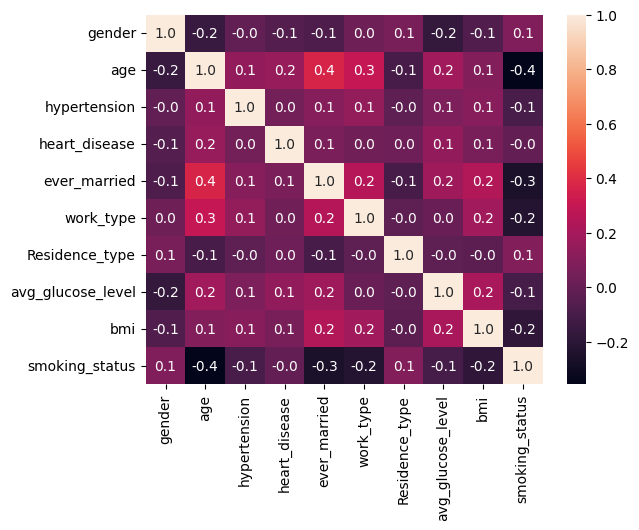

In [53]:
sns.heatmap(X_train.corr(method='spearman'), annot=True, fmt=".1f");